In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn

In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.3 MB/s eta 0:00:00


In [4]:
torch.manual_seed(104)
torch.cuda.manual_seed(104)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Data Preparation
Download data from:https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

In [5]:
raw_data = pd.read_csv("train.csv", index_col=0)

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [7]:
X = raw_data.copy()
y = X.pop('SalePrice')

In [8]:
from sklearn.model_selection import train_test_split

num_columns = X.select_dtypes(include='number').columns
cat_columns = X.select_dtypes('object').columns

X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=104)

# Gradient Boosting Model
We use CatBoost Package for Gradient Boosting model, because of categorical features in data.

In [9]:
#Simple prepocessing
X_train = X_train_raw.copy()
X_val = X_val_raw.copy()
X_train[cat_columns] = X_train[cat_columns].apply(lambda x: x.fillna('None'), axis=0)
X_val[cat_columns] = X_val[cat_columns].apply(lambda x: x.fillna('None'), axis=0)
means = X_train[num_columns].mean(axis=0)
X_train[num_columns] = X_train[num_columns].fillna(means)
X_val[num_columns] = X_val[num_columns].fillna(means)

In [10]:
from catboost import CatBoostRegressor

CBmodel = CatBoostRegressor(random_state=42, eval_metric='MSLE', loss_function='RMSE', thread_count=4, score_function='L2',
                           max_depth=6, n_estimators=1500, learning_rate=0.01, grow_policy='SymmetricTree')
CBmodel.fit(X_train, y_train, cat_features=list(cat_columns), verbose=100)

0:	learn: 0.1603224	total: 155ms	remaining: 3m 51s
100:	learn: 0.0532865	total: 4.73s	remaining: 1m 5s
200:	learn: 0.0271410	total: 8.87s	remaining: 57.3s
300:	learn: 0.0182360	total: 11.6s	remaining: 46.4s
400:	learn: 0.0143243	total: 14s	remaining: 38.4s
500:	learn: 0.0122694	total: 16.8s	remaining: 33.6s
600:	learn: 0.0109775	total: 19.2s	remaining: 28.7s
700:	learn: 0.0100441	total: 23s	remaining: 26.2s
800:	learn: 0.0093088	total: 25.4s	remaining: 22.1s
900:	learn: 0.0087322	total: 27.9s	remaining: 18.5s
1000:	learn: 0.0082508	total: 30.3s	remaining: 15.1s
1100:	learn: 0.0077799	total: 32.8s	remaining: 11.9s
1200:	learn: 0.0073392	total: 36.7s	remaining: 9.15s
1300:	learn: 0.0069320	total: 39.3s	remaining: 6.01s
1400:	learn: 0.0065922	total: 41.9s	remaining: 2.96s
1499:	learn: 0.0063024	total: 44.4s	remaining: 0us


Train loss: 0.08202372492520298 Val loss: 0.13759221108157277


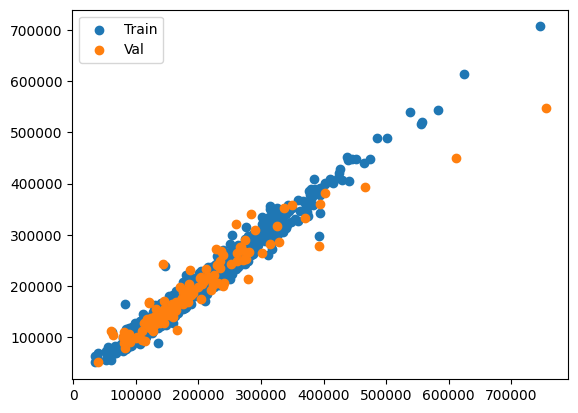

In [11]:
from sklearn.metrics import root_mean_squared_log_error

pred = CBmodel.predict(X_train)
print('Train loss:', root_mean_squared_log_error(pred, y_train), end=' ')
plt.scatter(y_train, pred, label='Train')
pred = CBmodel.predict(X_val)
print('Val loss:', root_mean_squared_log_error(pred, y_val))
plt.scatter(y_val, pred, label='Val')
plt.legend()
plt.show()

# Neural Network Model
## Data Preparation

In [12]:
from sklearn.base import TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

class Preprocessor(TransformerMixin):
    '''
    Scale numerical feature
    Add None category to each categorical feature
    Encode categorical features by positive numbers
    '''
    def __init__(self):
        self.enc = OrdinalEncoder(encoded_missing_value=-1, handle_unknown='error', dtype=np.int32)
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer()

    def fit(self, X: pd.DataFrame, numerical_columns, categorical_columns):
        X = pd.concat([pd.DataFrame([[np.nan]*(len(X.columns))], columns=X.columns), X])
        X[categorical_columns] = X[categorical_columns].apply(lambda x: x.fillna('None'), axis=0)
        self.enc.fit(X[categorical_columns])
        self.scaler.fit(X[numerical_columns])
        self.categorical_columns = categorical_columns
        self.numerical_columns = numerical_columns
        self.categorical_columns_index_by_name = {c: X.columns.get_loc(c) for c in categorical_columns}
        self.numerical_columns_index_by_name = {c: X.columns.get_loc(c) for c in numerical_columns}
        na_row = pd.DataFrame([[np.nan]*(len(X.columns))], columns=X.columns)
        na_row[self.categorical_columns] = na_row[self.categorical_columns].apply(lambda x: x.fillna('None'), axis=0)
        na_row[self.categorical_columns] = self.enc.transform(na_row[self.categorical_columns])
        self.categorical_code_by_index = {X.columns.get_loc(c): na_row[c][0] for c in self.categorical_columns}
        self.categorical_features_by_index = dict.fromkeys(self.categorical_columns_index_by_name.values())
        for index in self.categorical_columns_index_by_name.values():
            self.categorical_features_by_index[index] = len(pd.unique(X.iloc[:, index]))

    def transform(self, X: pd.DataFrame) -> torch.tensor:
        X = X.copy()
        X[self.categorical_columns] = X[self.categorical_columns].apply(lambda x: x.fillna('None'), axis=0)
        X[self.categorical_columns] = self.enc.transform(X[self.categorical_columns])
        X[self.numerical_columns] = self.scaler.transform(X[self.numerical_columns])
        return torch.tensor(X.to_numpy(), dtype=torch.float32)

In [13]:
preproc = Preprocessor()
preproc.fit(X_train_raw, num_columns, cat_columns)
X_train, X_val = preproc.transform(X_train_raw).to(device), preproc.transform(X_val_raw).to(device)
y_train, y_val = torch.tensor(y_train.to_numpy(), dtype=torch.float32, device=device), torch.tensor(y_val.to_numpy(), dtype=torch.float32, device=device)

In [14]:
class TransformTensorDataset(torch.utils.data.Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index].clone()
        if self.transform:
            x = self.transform(x)

        y = self.target[index]

        return x, y

class MVTransform:
    def __init__(self, transform_prob, col_number_dist, cat_nan_values):
        '''
        transform_prob: probability of transformation
        col_number_dist: scipy.stats discrete distribution
        cat_nan_values: dict cat column index: nan value
        '''
        self.transform_prob = transform_prob
        self.col_number_dist = col_number_dist
        self.uniform = np.random.default_rng(104)
        self.cat_nan_values = cat_nan_values

    def __call__(self, x):
        if self.uniform.random() < self.transform_prob:
            col_num = self.col_number_dist.rvs(size=1)
            transform_indexes = np.random.choice(np.arange(x.shape[-1]), size=col_num, replace=False)
            for index in transform_indexes:
                x[index] = self.cat_nan_values.get(index, np.nan)
        return x


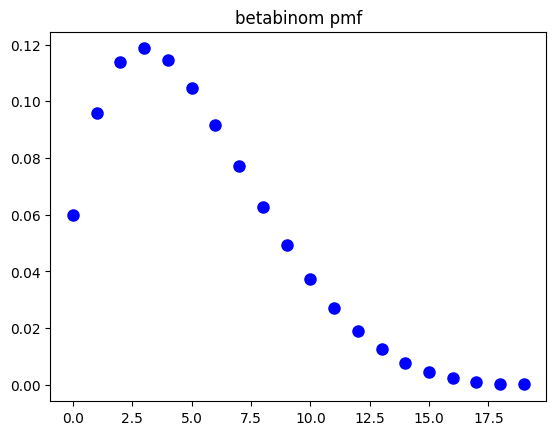

In [15]:
from scipy.stats import betabinom

n, a, b = 20, 2, 6

x = np.arange(0,n)
plt.plot(x, betabinom.pmf(x, n, a, b), 'bo', ms=8)
plt.title('betabinom pmf')
plt.show()

In [16]:
train_dataset = TransformTensorDataset(X_train, y_train, transform=MVTransform(0.1, betabinom(n, a, b), preproc.categorical_code_by_index))
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))

## Categorical feature embedding
First model uses embedding to categorical data. Embedding layer maps values of categorical feature $f$ to corresponding weight $w_i^f$, which will be learned in training process. Missing values in categorical data treaten as new categorical value. All categorical features processes in separate block, which return low dimension vector that encode categorical information.
Missing values in numerical feature imputed same way as categorical.

In [17]:
class HPmodel0CategoricalExtractor(nn.Module):
    def __init__(self, hidden_layers, categorical_features, dropout=0.2):
        '''
        hidden_layers: list of layers dims, exclude input and output layers
        categorical_features: dict, feature_index: num_categories
        dropout: dropout probability
        '''
        super().__init__()
        self.categorical_features = list(categorical_features.keys())
        self.embeddings = nn.ModuleDict({
            str(index): nn.Embedding(num_categories, 1)
            for index, num_categories in categorical_features.items()
        })
        self.fc = nn.Sequential()
        self.fc.append(nn.Linear(in_features=len(self.categorical_features), out_features=hidden_layers[0]))
        self.fc.append(nn.BatchNorm1d(hidden_layers[0]))
        self.fc.append(nn.ReLU())
        self.fc.append(nn.Dropout(dropout))
        for i in range(len(hidden_layers)-1):
            self.fc.append(nn.Linear(in_features=hidden_layers[i], out_features=hidden_layers[i+1]))
            self.fc.append(nn.BatchNorm1d(hidden_layers[i+1]))
            self.fc.append(nn.ReLU())
            self.fc.append(nn.Dropout(dropout))
    def forward(self, x):
        x = x.clone()
        for index in self.categorical_features:
            x[:, index] = self.embeddings[str(index)](x[:, index].type(torch.int32)).squeeze()
        return self.fc(x[:, self.categorical_features])

class HPmodel0MissingValueEmbendding(nn.Module):
    def __init__(self, features_number) -> None:
        super().__init__()
        self.embeddings = nn.Parameter(torch.randn(features_number))

    def forward(self, x):
        x = x.clone()
        for i in range(x.shape[-1]):
            x[:, i][x[:, i].isnan()] = self.embeddings[i]
        return x

class HPmodel0FeatureExtractor(nn.Module):
    def __init__(self, categorical_extractor_hidden_layers, categorical_features, numerical_features, hidden_layers, dropout=0.2):
        '''
        categorical_extractor_hidden_layers: dict of HPmodel0CategoricalExtractor parameteres
        categorical_features: dict, feature_index: num_categories
        numerical_features: list of feature indexes
        hidden_layers: list of layers dims, exclude input and output layers
        dropout: dropout probability
        '''
        super().__init__()
        self.numerical_features = numerical_features
        self.numerical_imputer = HPmodel0MissingValueEmbendding(len(numerical_features))
        self.categorical_extractor = HPmodel0CategoricalExtractor(hidden_layers=categorical_extractor_hidden_layers, categorical_features=categorical_features, dropout=dropout)
        self.fc = nn.Sequential()
        self.fc.append(nn.Linear(in_features=len(self.numerical_features) + categorical_extractor_hidden_layers[-1], out_features=hidden_layers[0]))
        self.fc.append(nn.BatchNorm1d(hidden_layers[0]))
        self.fc.append(nn.ReLU())
        self.fc.append(nn.Dropout(dropout))
        for i in range(len(hidden_layers)-1):
            self.fc.append(nn.Linear(in_features=hidden_layers[i], out_features=hidden_layers[i+1]))
            self.fc.append(nn.BatchNorm1d(hidden_layers[i+1]))
            self.fc.append(nn.ReLU())
            self.fc.append(nn.Dropout(dropout))

    def forward(self, x):
        cat_f = self.categorical_extractor(x)
        num_f = self.numerical_imputer(x[..., self.numerical_features])
        x = torch.cat((num_f, cat_f), dim=1)
        return self.fc(x)
    @torch.inference_mode()
    def evaluate(self, x):
        self.eval()
        return self.forward(x)

class HPmodel0Head(nn.Module):
    def __init__(self, in_features, hidden_layers, dropout=0.2):
        '''
        hidden_layers: list of layers dims, exclude input and output layers
        dropout: dropout probability
        '''
        super().__init__()
        self.fc = nn.Sequential()
        self.fc.append(nn.Linear(in_features=in_features, out_features=hidden_layers[0]))
        self.fc.append(nn.BatchNorm1d(hidden_layers[0]))
        self.fc.append(nn.ReLU())
        self.fc.append(nn.Dropout(dropout))
        for i in range(len(hidden_layers)-1):
            self.fc.append(nn.Linear(in_features=hidden_layers[i], out_features=hidden_layers[i+1]))
            self.fc.append(nn.BatchNorm1d(hidden_layers[i+1]))
            self.fc.append(nn.ReLU())
            self.fc.append(nn.Dropout(dropout))
        self.fc.append(nn.Linear(in_features=hidden_layers[-1], out_features=1))

    def forward(self, x):
        return self.fc(x)

class HPmodel0(nn.Module):
    def __init__(self, feature_extractor_param, head_param):
        '''
        feature_extractor_param: dict of HPmodel0FeatureExtractor parameteres
        head_param: dict of HPmodel0Head parameteres
        '''
        super().__init__()
        self.feature_extractor = HPmodel0FeatureExtractor(**feature_extractor_param)
        self.head = HPmodel0Head(**head_param)
    def forward(self, x: pd.DataFrame):
        x = self.feature_extractor(x)
        x = self.head(x)
        return x
    @torch.inference_mode()
    def evaluate(self, x):
        self.eval()
        return self.forward(x)
    def fit(self, train_dataloader, test_dataloader, epochs, optimizer, loss_fn, train_loss, test_loss):
        for epoch in tqdm(range(epochs)):
            #Train
            self.train()
            batch_loss = []
            for X_train, y_train in train_dataloader:
                y_pred = self.forward(X_train)
                loss = loss_fn(y_pred.squeeze(), y_train)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                batch_loss.append(torch.sqrt(loss).item())
            train_loss.append(np.array(batch_loss).mean())
            #Test
            batch_loss = []
            for X_test, y_test in test_dataloader:
                y_pred = self.evaluate(X_test)
                loss = loss_fn(y_pred.squeeze(), y_test)
                batch_loss.append(torch.sqrt(loss).item())
            test_loss.append(np.array(batch_loss).mean())

## Current best
* FE_param
```python
 {'categorical_extractor_hidden_layers': [30, 15, 10, 5],
        'hidden_layers': [70, 50, 40, 30, 20]}
```
head_param
```python
 {'hidden_layers': [10], 'in_features': 20}
```
* learning
> * epochs=1200, lr=0.1, MSELoss
> * epochs=500, lr=0.1, MSLELoss
> * epochs=1000, lr=0.001, MSLELoss                 

In [18]:
def print_learning_curve(train_loss, test_loss, drop:int = 0):
    plt.plot(train_loss[drop:], label='Train loss')
    plt.plot(test_loss[drop:], label='Test loss')
    plt.yscale('log')
    plt.legend()
    plt.title('Learning curve')
    plt.show()

class MSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, actual):
        return self.mse(torch.log(pred + 1), torch.log(actual + 1))

In [19]:
FE_param = {'categorical_extractor_hidden_layers': [30, 15, 10, 5],
        'categorical_features': preproc.categorical_features_by_index,
        'numerical_features': list(preproc.numerical_columns_index_by_name.values()),
        'hidden_layers': [70, 50, 40, 30, 20]}
head_param = {'hidden_layers': [10], 'in_features': 20}

model0 = HPmodel0(feature_extractor_param=FE_param, head_param=head_param)
model0 = model0.to(device)

100%|██████████| 1200/1200 [02:58<00:00,  6.71it/s]


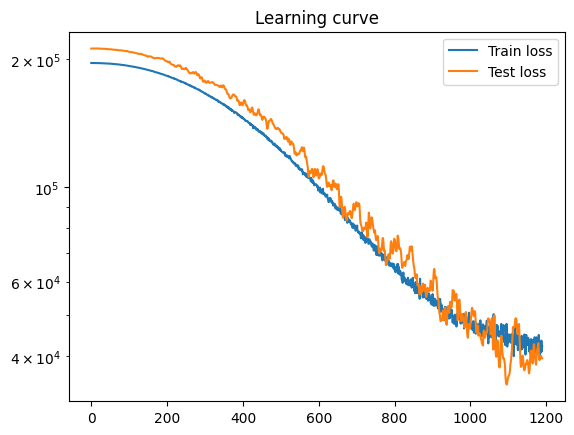

In [20]:
train_loss = []
test_loss = []
optim = torch.optim.Adam(model0.parameters(), lr=0.1)
model0.fit(train_dataloader=train_dataloader, test_dataloader=val_dataloader, epochs=1200, optimizer=optim, loss_fn=nn.MSELoss(),
           train_loss=train_loss, test_loss=test_loss)
print_learning_curve(train_loss, test_loss, drop=10)

100%|██████████| 1000/1000 [02:02<00:00,  8.15it/s]


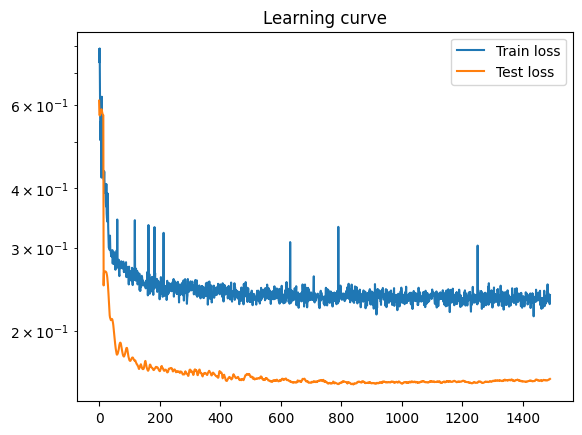

In [21]:
train_loss = []
test_loss = []
optim = torch.optim.Adam(model0.parameters(), lr=0.1)
model0.fit(train_dataloader=train_dataloader, test_dataloader=val_dataloader, epochs=500, optimizer=optim, loss_fn=MSLELoss(),
           train_loss=train_loss, test_loss=test_loss)
optim = torch.optim.Adam(model0.parameters(), lr=0.001)
model0.fit(train_dataloader=train_dataloader, test_dataloader=val_dataloader, epochs=1000, optimizer=optim, loss_fn=MSLELoss(),
           train_loss=train_loss, test_loss=test_loss)
print_learning_curve(train_loss, test_loss, drop=10)

Train loss: 0.10420449823141098 Val loss: 0.15830948948860168


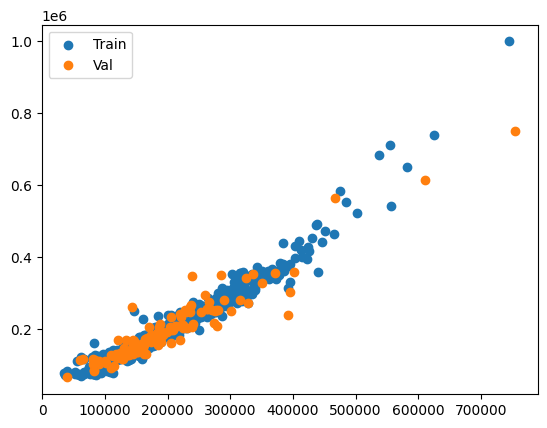

In [22]:
pred = model0.evaluate(X_train).cpu().numpy()
print('Train loss:', root_mean_squared_log_error(pred, y_train.cpu().numpy()), end=' ')
plt.scatter(y_train.cpu().numpy(), pred, label='Train')
pred = model0.evaluate(X_val).cpu().numpy()
print('Val loss:', root_mean_squared_log_error(pred, y_val.cpu().numpy()))
plt.scatter(y_val.cpu().numpy(), pred, label='Val')
plt.legend()
plt.show()

In [23]:
CBmodel = CatBoostRegressor(random_state=42, eval_metric='MSLE', loss_function='RMSE', thread_count=4, score_function='L2',
                           max_depth=6, n_estimators=1500, learning_rate=0.01, grow_policy='SymmetricTree')
FE_X_train = model0.feature_extractor.evaluate(X_train).cpu().numpy()
FE_y_train =  y_train.cpu().numpy()
FE_X_val = model0.feature_extractor.evaluate(X_val).cpu().numpy()
FE_y_val = y_val.cpu().numpy()

In [24]:
CBmodel.fit(X=FE_X_train, y=FE_y_train, verbose=100)

0:	learn: 0.1598345	total: 2.16ms	remaining: 3.24s
100:	learn: 0.0365659	total: 188ms	remaining: 2.61s
200:	learn: 0.0144480	total: 397ms	remaining: 2.57s
300:	learn: 0.0098402	total: 589ms	remaining: 2.35s
400:	learn: 0.0087267	total: 779ms	remaining: 2.13s
500:	learn: 0.0082613	total: 980ms	remaining: 1.95s
600:	learn: 0.0079625	total: 1.4s	remaining: 2.1s
700:	learn: 0.0076266	total: 1.91s	remaining: 2.18s
800:	learn: 0.0074358	total: 2.42s	remaining: 2.11s
900:	learn: 0.0072882	total: 2.87s	remaining: 1.91s
1000:	learn: 0.0071881	total: 3.3s	remaining: 1.64s
1100:	learn: 0.0071266	total: 3.82s	remaining: 1.38s
1200:	learn: 0.0070759	total: 4.09s	remaining: 1.02s
1300:	learn: 0.0070447	total: 4.28s	remaining: 655ms
1400:	learn: 0.0070012	total: 4.48s	remaining: 317ms
1499:	learn: 0.0069524	total: 4.67s	remaining: 0us


Train loss: 0.083381236740699 Val loss: 0.14849931910735878


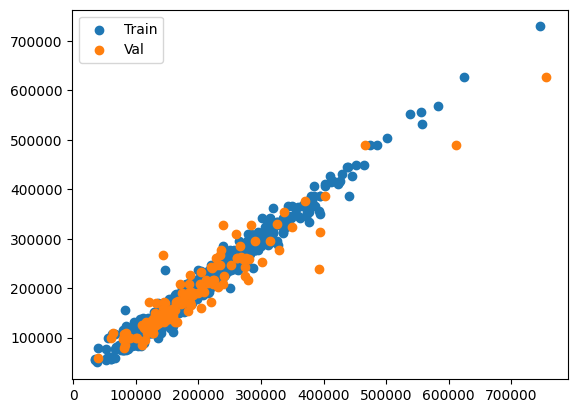

In [25]:
pred = CBmodel.predict(FE_X_train)
print('Train loss:', root_mean_squared_log_error(pred, FE_y_train), end=' ')
plt.scatter(FE_y_train, pred, label='Train')
pred = CBmodel.predict(FE_X_val)
print('Val loss:', root_mean_squared_log_error(pred, FE_y_val))
plt.scatter(FE_y_val, pred, label='Val')
plt.legend()
plt.show()

In [26]:
torch.save(model0.state_dict, './model0_state_dict.pt')